In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [9]:
class GridEnvironment:
    def __init__(self, size=30, num_obstacles=100):
        self.size = size
        self.num_obstacles = num_obstacles
        self.grid = np.zeros((size, size))
        self.start, self.goal = self._place_start_goal()
        self.obstacles = self._create_obstacles()
        self.state = self.start

    def _place_start_goal(self):
        start = (0, 0)  # Fixed start position for simplicity
        goal = (self.size - 1, self.size - 1)  # Fixed goal position
        return start, goal

    def _create_obstacles(self):
        obstacles = set()
        while len(obstacles) < self.num_obstacles:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (x, y) != self.start and (x, y) != self.goal:
                obstacles.add((x, y))
                self.grid[x, y] = -1  # Mark obstacle
        return obstacles

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        x, y = self.state
        if action == 0:  # Up
            new_state = (max(x - 1, 0), y)
        elif action == 1:  # Down
            new_state = (min(x + 1, self.size - 1), y)
        elif action == 2:  # Left
            new_state = (x, max(y - 1, 0))
        elif action == 3:  # Right
            new_state = (x, min(y + 1, self.size - 1))

        # Check for obstacles
        if new_state in self.obstacles:
            reward = -1  # Penalty for hitting an obstacle
            new_state = self.state  # Stay in place
        elif new_state == self.goal:
            reward = 1  # Reward for reaching the goal
        else:
            reward = -0.01  # Small penalty for each step

        self.state = new_state
        done = self.state == self.goal
        return new_state, reward, done

    def render(self):
        grid_copy = self.grid.copy()
        grid_copy[self.start] = 0.5  # Start
        grid_copy[self.goal] = 0.8  # Goal
        plt.title("Grid Environment")
        plt.imshow(grid_copy, cmap='gray')
        plt.show()

In [12]:
class QLearningAgent:
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.9):
        self.env = environment
        self.q_table = np.zeros((environment.size, environment.size, 4))  # Q-values for each state-action pair
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 3)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_delta

    def train(self, episodes=10000):
        for _ in tqdm(range(episodes), desc="Training Episodes"):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update(state, action, reward, next_state)
                state = next_state

Training Episodes: 100%|██████████| 10000/10000 [01:08<00:00, 146.43it/s]


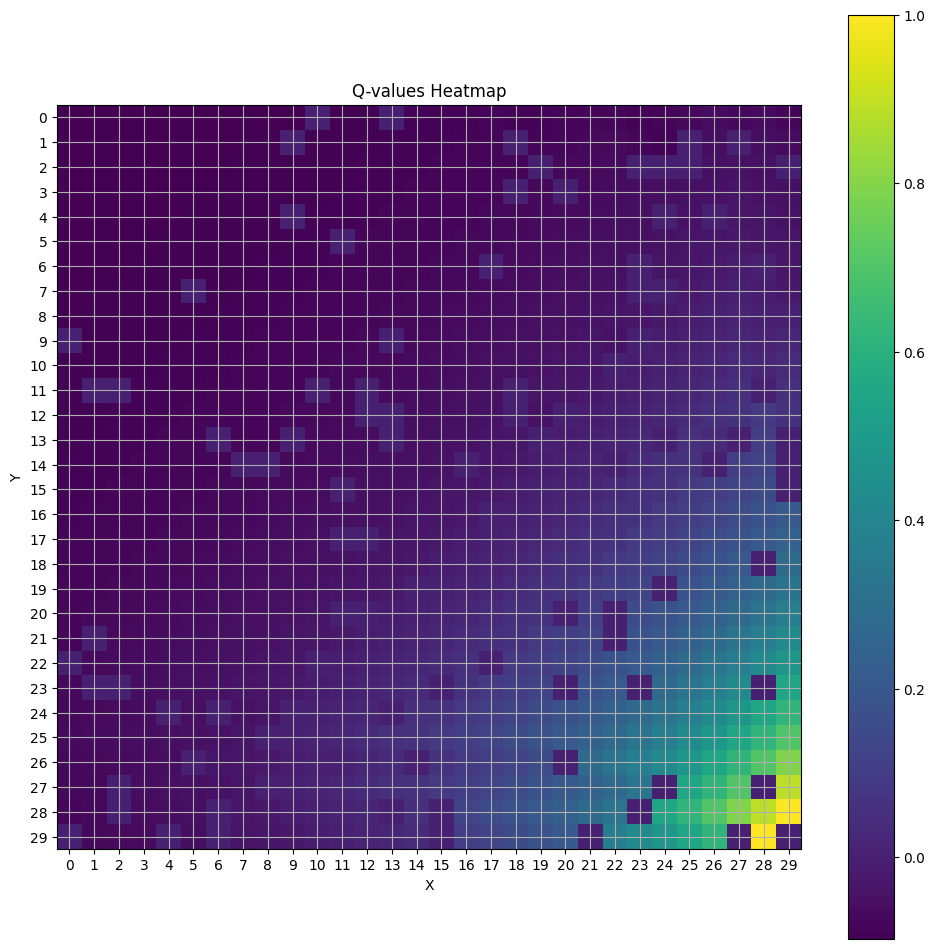

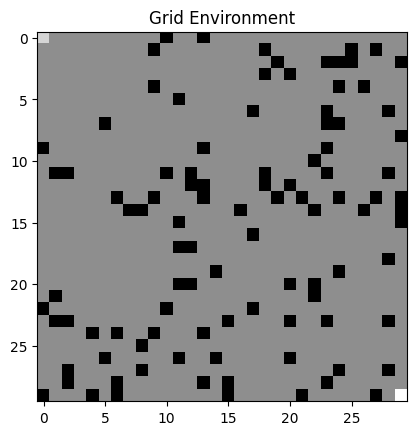

In [13]:
def main():
    env = GridEnvironment()
    agent = QLearningAgent(env)
    agent.train(episodes=10000)

    # Visualize the Q-values with improved color range and layout
    fig, ax = plt.subplots(figsize=(12, 12))
    q_values = np.max(agent.q_table, axis=2)
    im = ax.imshow(q_values, cmap='viridis')
    ax.set_title("Q-values Heatmap")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xticks(np.arange(env.size))
    ax.set_yticks(np.arange(env.size))
    ax.grid(True)
    plt.colorbar(im, ax=ax)
    plt.show()

    # Run the simulation
    state = env.reset()
    done = False
    while not done:
        action = agent.choose_action(state)
        state, _, done = env.step(action)
    env.render()

if __name__ == "__main__":
    main()